# Autograd package in PyTorch

The goal of this notebook is to play around with this package to get a better understanding of how PyTorch does automatic differentiation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

import torch
from torch.autograd import Variable, grad

### Variables

We need to wrap our tensors as variables to be able to generate the back propagation and our gradients.

Here, we create a simple scaler value $x=4$.  Even though it is nondimensional, we still need to make it a tensor.

In [2]:
x = Variable(torch.FloatTensor([4]), requires_grad=True)
print(x)
print(x.grad)

tensor([4.], requires_grad=True)
None


### Single variable polynomial

## $z = x^{3} + 2x^{2} + 8x$

We will use a lambda function for this polynominal

In [3]:
func_1 = lambda x: torch.pow(x, 3) + 2*torch.pow(x, 2) + 8*x

### First Derivative

Let's manually do the math to get the first derivative and evaluate it for $x=4$.

### $\frac{dz}{dx} = 3x^{2} + 4x + 8$

### $\frac{dz}{dx}\Bigr|_{\substack{x=4}} \quad 3*4^{2} + 4*4 + 8 = 72$

### Now let's see if PyTorch gets the same results

Generate a new tensor $z$ that is the result of our function.

We then take this result tensor and run the back propagation method.

This sets the input variable $x$ grad attribute to first derivative evaluated at $x=4$.

In [4]:
z = func_1(x)
z.backward()
print(x.grad)

tensor([72.])


##### The computational graph (see below) is released automatically on the backward() call.  So running backward() twice throws an error

In [5]:
try:
    z.backward()
except RuntimeError as err:
    print(err)

Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.


##### If we tell PyTorch to ratain the computation graph, we can run backward() multiple times

But all this does is add sum the gradients again.

i.e. This does NOT do the second derivative 

72

72+72=144

72+72+72=216

In [6]:
# reset the grad and find z again
x.grad.data.zero_()
z = func_1(x)

z.backward(retain_graph = True)
print(x.grad)
z.backward(retain_graph = True)
print(x.grad)
z.backward()
print(x.grad)

tensor([72.])
tensor([144.])
tensor([216.])


## Computation Graph

Let's write our polynomial as composite functions to show how it would look as a computational graph.

There are 3 terms in the polynomial, so this will create 3 branches in our computational graph.

## $z = x^{3} + 2x^{2} + 8x$

### Branch A: $x^3$

- $\dot{A_1} = 3x^2 \quad \rightarrow \quad \dot{A_1}\Bigr|_{\substack{x=4}} = 48$

### Branch B: $2x^2$

- $\dot{B_1} = 2x \quad \rightarrow \quad \dot{B_1}\Bigr|_{\substack{x=4}} = 8$


- $\dot{B_2} = 2\dot{B_1} \quad \rightarrow \quad \dot{B_2}\Bigr|_{\substack{x=4}} = 2 \times 8 = 16$ *(chain rule)*

### Branch C: $8x$

- $\dot{C_1} = 8 \quad \rightarrow \quad \dot{C_1}\Bigr|_{\substack{x=4}} = 8$

### Final Gradient for x=4:
- $\dot{A_1} + \dot{B_2} + \dot{C_1} = 48 + 16 + 8 = 72$

## This is how the gradient for the forward propagation is stored.  

PyTorch does not use calculus per se, it has a set of known derivative equations for most math functions.

During the forward, these local gradient values are stored for each branch and each step in that branch.

On back propagation, the chain rule is used.  For each branch, basically all that needs to be done is to multiple all the local gradients together to the the final gradient, which makes for a very efficient process since only basic math operators are used.

From PyTorch's perspective, the backwards() call boils down to a series of matrix multiplications.

#### Last Local Gradient

You can think of the final local gradiant as $\frac{\partial{z}}{\partial{z}}$ which is always equal to 1.

## Now let's look at a single branch function with sevaral steps

This will give us a better look at how a branch stores the local gradients.

### $z = i \circ h \circ g \circ f $

- $f(x) = 2x$
- $g(f) = f^4$
- $h(g) = {3.14}g$
- $i(h) = \sqrt[3]{h}$
- $z=i$

### Let's look the derivatives for each step:
- $\frac{\partial{f}}{\partial{x}} = 2$
- $\frac{\partial{g}}{\partial{f}} = 4f^3$
- $\frac{\partial{h}}{\partial{g}} = 3.14$
- $\frac{\partial{i}}{\partial{h}} = \frac{1}{2\sqrt{h}}$
- $\frac{\partial{z}}{\partial{i}} = 1$

### Now evaluate these with $x=4$:
- $f(4) = 8$
- $g(f) = 8^4 = 4096$
- $h(g) = 3.14 \times 4096 = 12861.44$
- $i(h) = \sqrt{12861.44} = 113.4083$


- $\frac{\partial{f}}{\partial{x}} = 2$
- $\frac{\partial{g}}{\partial{f}} = 4f^3 = 4 \times 8^3 = 2048$
- $\frac{\partial{h}}{\partial{g}} = 3.14$
- $\frac{\partial{i}}{\partial{h}} = \frac{1}{2\sqrt{h}} = \frac{1}{2\sqrt{12861.44}} = 0.004408849$
- $\frac{\partial{z}}{\partial{i}} = 1$

### Now we get the backwards local gradients via the chain rule (simple multiplication):
- $\frac{\partial{z}}{\partial{i}} = 1$
- $\frac{\partial{z}}{\partial{h}} = \frac{\partial{z}}{\partial{i}} \cdot \frac{\partial{i}}{\partial{h}}$
- $\frac{\partial{z}}{\partial{g}} = \frac{\partial{z}}{\partial{i}} \cdot \frac{\partial{i}}{\partial{h}}  \cdot \frac{\partial{h}}{\partial{g}}$
- $\frac{\partial{z}}{\partial{f}} = \frac{\partial{z}}{\partial{i}} \cdot \frac{\partial{i}}{\partial{h}}  \cdot \frac{\partial{h}}{\partial{g}} \cdot \frac{\partial{g}}{\partial{f}}$
- $\frac{\partial{z}}{\partial{x}} = \frac{\partial{z}}{\partial{i}} \cdot \frac{\partial{i}}{\partial{h}}  \cdot \frac{\partial{h}}{\partial{g}} \cdot \frac{\partial{g}}{\partial{f}} \cdot \frac{\partial{f}}{\partial{x}}$

### The local gradients evaluated with $x=4$:

- $\frac{\partial{z}}{\partial{i}} = \textbf{1}$


- $\frac{\partial{z}}{\partial{h}} = 1 \times 0.004408849 = \textbf{0.004408849}$


- $\frac{\partial{z}}{\partial{g}} = 0.004408849 \times 3.14 = \textbf{0.01384378586}$


- $\frac{\partial{z}}{\partial{f}} = 0.01384378586 \times 2048 = \textbf{28.35207344128}$


- $\frac{\partial{z}}{\partial{x}} = 28.35207344128 \times 2 = \textbf{56.70414688256}$


In [7]:
comp_f = lambda x: 2 * x
comp_g = lambda f: torch.pow(f, 4)
comp_h = lambda g: 3.14 * g
comp_i = lambda h: torch.sqrt(h)

x = Variable(torch.FloatTensor([4]), requires_grad=True)
f = comp_f(x); g = comp_g(f); h = comp_h(g); i = comp_i(h); z=i

print('Result of composit functions (x=4):\nz = i =', i.item())

# By default, PyTorch disposes the local gradients on backprop except for the leaf level
# But we can put in a hook to show what these interim local gradient values are
printf = lambda f: print('dz/df: ', f.item()); printg = lambda g: print('dz/dg: ', g.item())
printh = lambda h: print('dz/dh: ', h.item()); printi = lambda i: print('dz/di: ', i.item())
print("\nLocal Gradients:")
f.register_hook(printf); g.register_hook(printg); h.register_hook(printh); i.register_hook(printi)

z.backward()
print('\nFinal Gradient (x=4)\ndz/dx: ', x.grad.item())

Result of composit functions (x=4):
z = i = 113.40828704833984

Local Gradients:
dz/di:  1.0
dz/dh:  0.004408848937600851
dz/dg:  0.013843785971403122
dz/df:  28.352073669433594

Final Gradient (x=4)
dz/dx:  56.70414733886719


## Gradient Descent of Loss Function

#### Normally, we get the gradiant on a loss function.  If we want the loss to be less, we go in the oppisit direction of the gradient. 

$\Delta x = -\frac{\partial{z}}{\partial{x}}$

We then repeat changing x by $\Delta x$ to decrease the loss.

In [8]:
x_value = 23
learning_rate = 1e-1
for iteration in range(1, 11):
    x = Variable(torch.FloatTensor([x_value]), requires_grad=True)
    f = comp_f(x)
    g = comp_g(f)
    h = comp_h(g)
    i = comp_i(h)
    loss=i
    
    print(u"\u2585" * 30)
    print(f'Iteration: {iteration}')
    print(u"\u2585" * 30)

    print('New x: ', x_value)
    print(f'Loss: ', loss.item())

    loss.backward()

    print(f'dz/dx: ', x.grad.item())
    
    print('\n' * 2)

    x_value = x_value - (learning_rate * x.grad.item())

▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Iteration: 1
▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
New x:  23
Loss:  3749.5615234375
dz/dx:  326.048828125



▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Iteration: 2
▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
New x:  -9.604882812500001
Loss:  653.896484375
dz/dx:  -136.1591796875



▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Iteration: 3
▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
New x:  4.011035156249999
Loss:  114.03488159179688
dz/dx:  56.86058044433594



▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Iteration: 4
▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
New x:  -1.6750228881835945
Loss:  19.886863708496094
dz/dx:  -23.74518394470215



▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Iteration: 5
▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
New x:  0.6994955062866204
Loss:  3.4681243896484375
dz/dx:  9.9160737991333



▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Iteration: 6
▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
New x:  -0.29211187362670976
Loss:  0.6048159599304199
dz/dx:  -4.140988349914551



▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Iteration: 7
▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
New x:  0.1

### Let's try this on a non-polynominal function

$z = {sin({6x})}^2 \times {2x}^{2} \times {|x|}$

In [9]:
def non_poly(x):
    return torch.pow(torch.sin(6*x), 2) * torch.pow(2*x, 2) * torch.abs(x)

x = Variable(torch.FloatTensor([1.8]), requires_grad=True) 
z = non_poly(x)
z.backward()
print('z:', z.item())
print(f'dz/dx: ', x.grad.item())

z: 22.44702911376953
dz/dx:  90.7747802734375


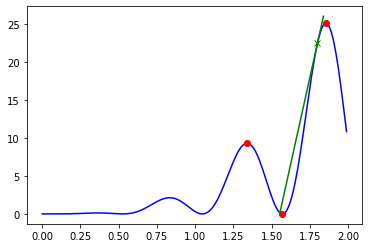

In [10]:
X = torch.from_numpy(np.arange(0, 2, .01))
Z = non_poly(X)
plt.plot(X, Z, color='b')
plt.plot(1.33974, 9.295228958129883, marker='o', color='r')
plt.plot(1.85492, 25.0738, marker='o', color='r')
plt.plot(np.pi / 2, 0, marker='o', color='r')
plt.plot(1.8, 22.447, marker='x', color='g')
plt.plot([1.55262, 1.83905], [0, 26], color='g')
plt.show()

### As you can see from the plot above, our non_poly function is anything but linear

There are several local maximas and minimas with x between 0 and 2.

The are local maximas around x = 1.33974 and x = 1.85492.

There is a local minima at $\frac{\pi}{2} \approx 1.570796$

#### So, let's start our gradient descent at x = 1.8, just before a local maxima.

The slope at this point is about 90.774.

So we will adjust the value of x in the following way:
- $\Delta{x} = {-1} \times (90.772 \times learning_rate)$

If the learning rate = 1e-1, this would give:
- $\Delta{x} = {-1} \times (90.772 \times .1) = -9.0772$
- $x + \Delta{x} = 1.8 - 9.0772 = -7.2772$

But with this much change, we would move across multiple local minimas and not even be in this plot above.

### Picking the right learning rate is critical:

If the learning rate = 1e-3, this would give:
- $\Delta{x} = {-1} \times (90.772 \times .001) = -0.090772$
- $x + \Delta{x} = 1.8 - 0.090772 = 1.709228$

This makes the change in x much smaller as keeps us between the 2 local minimas.

*Note: We don't want just find the local minima, but the global minima.*
*In this case, the local minimas happen to be zero so we would be ok.*
*We will need to account for getting stuck in local minimas with things like stochastic gradient descent vs Adam optimizers, but this is out of scope for this notebook*

### Let's run several iterations of gradient descent for out non_poly function with 3 different learning rates

#### Our goal will be to get to:
### $x = \frac{\pi}{2} \approx 1.570796$

In [11]:
def gradientDescentNonPoly(initial_x, iterations, learning_rate):
    print(u"\u2585" * 30)
    print(f'LR={learning_rate}')
    print(u"\u2585" * 30)
    x_value = initial_x   
    for iteration in range(1, iterations+1):
        x = Variable(torch.FloatTensor([x_value]), requires_grad=True)
        loss=non_poly(x)

        print("-" * 30)
        print(f'Iteration: {iteration}')
        print("-" * 30)

        loss.backward()

        print('x: ', x_value)
        print(f'Loss: ', loss.item())
        print(f'dz/dx: ', x.grad.item())

        x_value = x_value - (learning_rate * x.grad.item())
        
        
gradientDescentNonPoly(initial_x = 1.8, iterations=6, learning_rate=1e-1)    
gradientDescentNonPoly(initial_x = 1.8, iterations=6, learning_rate=1e-2) 
gradientDescentNonPoly(initial_x = 1.8, iterations=6, learning_rate=1e-3)   

▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
LR=0.1
▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
------------------------------
Iteration: 1
------------------------------
x:  1.8
Loss:  22.44702911376953
dz/dx:  90.7747802734375
------------------------------
Iteration: 2
------------------------------
x:  -7.27747802734375
Loss:  150.1937713623047
dz/dx:  5424.029296875
------------------------------
Iteration: 3
------------------------------
x:  -549.6804077148437
Loss:  205495120.0
dz/dx:  3683689472.0
------------------------------
Iteration: 4
------------------------------
x:  -368369496.88040775
Loss:  8.620856699699118e+23
dz/dx:  1.572076355549627e+26
------------------------------
Iteration: 5
------------------------------
x:  -1.5720763555496272e+25
Loss:  inf
dz/dx:  nan
------------------------------
Iteration: 6
------------------------------
x:  nan
Loss:  nan
dz/dx:  nan
▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
LR=0.01
▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
------------------------------
Iteration: 1
-----------

### We were able to get to our goad with the learning rate of 1e-3

After 6 iterations, we got to x=1.570796 which is our expected goal (with 7 sig figs) and got our loss function to almost zero!

## Functions with multiple variables

So far, we have only looked at functions with a single variable x.

Let look to see what happens with a function with 2 variables x and y.

## Polynominal with 2 variables

### $z = x^{3} + y^{2} + x + 6$

$\frac{\partial z}{\partial x} = 3x^{2} + 1$

$\frac{\partial z}{\partial x}\Bigr|_{\substack{x=4}} \quad 3*4^{2} + 1 = 49$

$\frac{\partial z}{\partial y} = 2y$

$\frac{\partial z}{\partial y}\Bigr|_{\substack{y=2}} \quad 2*2 = 4$

In [12]:
x=4; y=2
XY = Variable(torch.FloatTensor([x, y]), requires_grad=True)

print(f'[x, y] = {XY.data.numpy()}')

def elip(XY):
    X = XY[0]
    Y = XY[1]
    return torch.pow(X, 3) + torch.pow(Y, 2) + X + 6
Z = elip(XY)

print('\nValue of Z: ', Z.item(), '\n')

Z.backward()
print(f'[dz/dx, dz/dy] = {XY.grad.data.numpy()}') 

[x, y] = [4. 2.]

Value of Z:  78.0 

[dz/dx, dz/dy] = [49.  4.]


#### There is not much different here other then our function took in 2 variables

Since the input was 2 different variables, the gradient returns 2 values.

### Now let's take our 2 variable function and supply it with multiple rows

Think of each row as a new sample:
- Person A: x=4, y=2
- Person B: x=3, y=2
- Person C: x=4, y=3

In [13]:
XY = Variable(torch.FloatTensor([[4, 2],
                                 [3, 2],
                                 [4, 3]]), requires_grad=True)

print(f'Person A: [x, y] = {XY[0].data.numpy()}')
print(f'Person B: [x, y] = {XY[1].data.numpy()}')
print(f'Person C: [x, y] = {XY[2].data.numpy()}\n')                                 

def multi_row_elip(XY):
    X = XY[:,0]
    Y = XY[:,1]
    return torch.pow(X, 3) + torch.pow(Y, 2) + X + 6
Z = multi_row_elip(XY)

print(f'Person A: z = {Z[0].item()}')
print(f'Person B: z = {Z[1].item()}')
print(f'Person C: z = {Z[2].item()}\n')  

row_count = XY.shape[0]
vector_of_ones = torch.ones(row_count)
Z.backward(vector_of_ones) #Explained below

print(f'Person A: [dz/dx, dz/dy] = {XY.grad.data[0].numpy()}') 
print(f'Person B: [dz/dx, dz/dy] = {XY.grad.data[1].numpy()}') 
print(f'Person C: [dz/dx, dz/dy] = {XY.grad.data[2].numpy()}') 

Person A: [x, y] = [4. 2.]
Person B: [x, y] = [3. 2.]
Person C: [x, y] = [4. 3.]

Person A: z = 78.0
Person B: z = 40.0
Person C: z = 83.0

Person A: [dz/dx, dz/dy] = [49.  4.]
Person B: [dz/dx, dz/dy] = [28.  4.]
Person C: [dz/dx, dz/dy] = [49.  6.]


### Now, let's look at this using the Iris Dataset

This should give us a better feel for how this applies to neural networks.

We will use a simple function for Z now, but will replace this will an a function will a real loss function down the road.

In [14]:
iris = load_iris()
iris_samples = iris.data
iris_targets = iris.target


print('Target Names: ', iris.target_names, '\n')
row_count = iris_samples.shape[0]
print('Row Count: ', row_count)
print('Feature Count: ', iris_samples.shape[1])
print('Feature Names: ', iris.feature_names, '\n')

# a single row (or sample) from the 3 species can be seen with these indexes: 25, 75, 125

iris_samples_tensor = Variable(torch.FloatTensor(iris_samples), requires_grad=True)

print('Input Data:')
print(f'sample of setosa: data = {list(iris_samples_tensor[25].data.numpy())}')
print(f'sample of versicolor: data = {list(iris_samples_tensor[75].data.numpy())}')
print(f'sample of virginica: data = {list(iris_samples_tensor[125].data.numpy())}\n')  

def iris_surface_area_function(iris_samples):
    sl = iris_samples[:,0]
    sw = iris_samples[:,1]
    pl = iris_samples[:,2]
    pw = iris_samples[:,3]
    return sl * sw + pl * pw # Sort of area of sepal + area of petal

Z = iris_surface_area_function(iris_samples_tensor)

print('Function Results:')
print(f'sample of setosa: z = {Z[25].item()}')
print(f'sample of versicolor: z = {Z[75].item()}')
print(f'sample of virginica: z = {Z[125].item()}\n')  

vector_of_ones = torch.ones(row_count)
Z.backward(vector_of_ones) #Explained below

print('Gradients:')
grad_string = '[dz/d(sl), dz/d(sw), dz/d(pl), dz/d(pw)]' #with repect to sepal length/width petal length/width
print(f'sample of setosa: {grad_string} = {list(iris_samples_tensor.grad.data[25].numpy())}') 
print(f'sample of versicolor: {grad_string} = {list(iris_samples_tensor.grad.data[75].numpy())}') 
print(f'sample of virginica: {grad_string} = {list(iris_samples_tensor.grad.data[125].numpy())}') 

Target Names:  ['setosa' 'versicolor' 'virginica'] 

Row Count:  150
Feature Count:  4
Feature Names:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'] 

Input Data:
sample of setosa: data = [5.0, 3.0, 1.6, 0.2]
sample of versicolor: data = [6.6, 3.0, 4.4, 1.4]
sample of virginica: data = [7.2, 3.2, 6.0, 1.8]

Function Results:
sample of setosa: z = 15.319999694824219
sample of versicolor: z = 25.959999084472656
sample of virginica: z = 33.839996337890625

Gradients:
sample of setosa: [dz/d(sl), dz/d(sw), dz/d(pl), dz/d(pw)] = [3.0, 5.0, 0.2, 1.6]
sample of versicolor: [dz/d(sl), dz/d(sw), dz/d(pl), dz/d(pw)] = [3.0, 6.6, 1.4, 4.4]
sample of virginica: [dz/d(sl), dz/d(sw), dz/d(pl), dz/d(pw)] = [3.2, 7.2, 1.8, 6.0]


### This function is contrived, and probably is not a great way to predict the 3 species

#### But the intention here is to show how a gradient works with multiple features and rows.

We can see from the gradients, which features have a bigger influence on the function result Z.

Across the 3 samples of the 3 species, you can see that the first 2 gradients are larger.  These are the gradients for sepal length and sepal width.  Of these 2 gradients, the sepal width has a larger gradient and therefore a larger influence on Z.  For Versicolor and Virginica, the last gradient (petal width) also has a pretty strong influence on Z.


## Vector of Ones

We need to explain what this is why we sometimes need to pass this into our backward() function call.

This vector is passed for the gradient parameter of the backward() call.  

It's "default" value is **torch.ones([1])**.

You can think of the **1** value as the number of rows. 

Most loss functions reduce the output to a single scalar value.  Therefor, the number of "rows" returned by the function is **1**.

But some loss functions can produce multiple rows.  An example of this would be **BCEWithLogitsLoss(reduction=None)**.

If the function result we call returns **n** rows, we need to pass in **torch.ones([n])** into the backward() call.

A good way of thinking about this is that each sample (or row) of input data gets its own value from the function call.  So each row is a result with it's own gradient.

### But why is it done this way?

Remember that each step in the computational graph retains the local gradient value from the forward pass.  The backward pass simply multiples each value in each step.  This follows the chain rule.

But unlike our simple examples above, there are multiple variables and multiple rows.  So these local gradient values are not simple scalars, but a matrix of values of shape $n \times m$, with **n** = number of rows and **m** = number of features.

In our computational graph examples above, we always always started the back prop multiplication with 1, the derivative of the function with respect to itself.  

This vector of ones is simply this same starting point, but we need ones for each row of data.

PyTorch follows a process called the Jacobian Vector Product of JVP for back propagation.  The stored local gradient values is the Jacobian Matrix and the vector of ones is the Vector.  


Let's say the function result of a row is $y_1$.  Then the gradient with 3 features $[x_1, x_2, x_3]$ would look like this:

$\frac{\partial y_1}{\partial x_1}, \frac{\partial y_1}{\partial x_2}, \frac{\partial y_1}{\partial x_3}$

The gradient for the next row $y_2$ is:

$\frac{\partial y_2}{\partial x_1}, \frac{\partial y_2}{\partial x_2}, \frac{\partial y_2}{\partial x_3}$

Symbolically, the Jacobian looks like this for 3 features [$x_1, x_2, x_3$] with 3 rows of results [$y_1, y_2, y_3$]


$\begin{pmatrix}
  \frac{\partial y_1}{\partial x_1} & \frac{\partial y_1}{\partial x_2} & \frac{\partial y_1}{\partial x_3} \\ 
  \frac{\partial y_2}{\partial x_1} & \frac{\partial y_2}{\partial x_2} & \frac{\partial y_2}{\partial x_3}\\ 
  \frac{\partial y_3}{\partial x_1} & \frac{\partial y_3}{\partial x_2} & \frac{\partial y_3}{\partial x_3}
\end{pmatrix}$

Since PyTorch doesn't do symbolic calculus, only the local gradients are stored.

So the "Jacobian" might look something like:

$\begin{pmatrix}
  0.145 & 24.6 & 1.57 \\ 
  135 & 0.457 & 45.24\\ 
 .001 & -75.4 & -22
\end{pmatrix}$


The shape of this Jacobian depends on where in the back propagation we are.  

For most loss functions, we reduced all the features into a single loss value.  We also do some kind of average of all the samples or rows to produce a scalar value.  So the bigining of the backward process starts with the Jacobian as 1x1.

The Jacobian shape will change as it goes back.  For example, a loss function that reduces features first, then reduces rows second would have the following shape changes, with n = number of rows and m = number of feature:
- 1x1
- nx1
- nxm

In our first example $z = x^{3} + 2x^{2} + 8x$, we only had one function and one independent variable. so the Jacobian was simply:


$\begin{pmatrix}72\end{pmatrix}$

The first Jacobian Vector Product (JVP) for our one row one feature polynomial function would be:

$\begin{pmatrix}72\end{pmatrix} \cdot \begin{pmatrix}1\end{pmatrix} = \begin{pmatrix}72\end{pmatrix}$

#### For functions that do NOT reduce the rows or variables, the vector of ones needs to match the shape of the output of the function

The JVP might look like this:

$\begin{pmatrix}
  0.145 & 24.6 & 1.57 \\ 
  135 & 0.457 & 45.24 \\ 
 .001 & -75.4 & -22
\end{pmatrix} \odot \begin{pmatrix}1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{pmatrix} =
\begin{pmatrix}
  0.145 & 24.6 & 1.57 \\ 
  135 & 0.457 & 45.24 \\ 
 .001 & -75.4 & -22
\end{pmatrix}$

## Back to our Iris Example

#### We have 2 major problems with our Iris example above!
- The function is not a loss function comparing predicted to actual targets
- The gradients are on the features

Looking at the latter, knowing that sepal width is a strong influence does not help us.  Above, we would use these gradients to change the value of the inputs.  But we can't change the measured sepal width of an observation!!! 

We need to add weights to each observation.  Since we can change the weights but cannot change the observations, we will look at the gradients of the weights and make adjustments to these weights.

#### Let's put in a real loss function first and add the weights later

In [16]:
iris_samples_tensor = Variable(torch.FloatTensor(iris_samples), requires_grad=True)
iris_targets_tensor = Variable(torch.FloatTensor(iris_targets), requires_grad=True)

print('Input Data:')
print(f'sample of setosa: data = {list(iris_samples_tensor[25].data.numpy())}')
print(f'sample of versicolor: data = {list(iris_samples_tensor[75].data.numpy())}')
print(f'sample of virginica: data = {list(iris_samples_tensor[125].data.numpy())}\n') 

# Make same function we used above, but this is just an interim result
iris_surface_areas = iris_surface_area_function(iris_samples_tensor)

"""
The loss funciton will:
 1) Take in "surface areas"
 2) Squash these areas using the sigmoid function
 3) Use BCELoss (binary cross entropy) to return a loss value
The cross entopy compares the sigmoid value to the actual binary target
reduction='none' will retun a loss value for each row submitted
"""

loss_function = torch.nn.BCEWithLogitsLoss(reduction='none')
loss = loss_function(iris_surface_areas, iris_targets_tensor)

print('Loss Function Results:')
print(f'sample of setosa: loss = {loss[25].item()}')
print(f'sample of versicolor: loss = {loss[75].item()}')
print(f'sample of virginica: loss = {loss[125].item()}\n')  

vector_of_ones = torch.ones(row_count)
loss.backward(vector_of_ones)

print('Gradients:')
grad_string = '[dl/d(sl), dl/d(sw), dl/d(pl), dl/d(pw)]' #with repect to sepal length/width petal length/width
print(f'sample of setosa: {grad_string} = {list(iris_samples_tensor.grad.data[25].numpy())}') 
print(f'sample of versicolor: {grad_string} = {list(iris_samples_tensor.grad.data[75].numpy())}') 
print(f'sample of virginica: {grad_string} = {list(iris_samples_tensor.grad.data[125].numpy())}') 

Input Data:
sample of setosa: data = [5.0, 3.0, 1.6, 0.2]
sample of versicolor: data = [6.6, 3.0, 4.4, 1.4]
sample of virginica: data = [7.2, 3.2, 6.0, 1.8]

Loss Function Results:
sample of setosa: loss = 15.319999694824219
sample of versicolor: loss = 0.0
sample of virginica: loss = -33.839996337890625



RuntimeError: Mismatch in shape: grad_output[0] has a shape of torch.Size([3, 2]) and output[0] has a shape of torch.Size([150]).

### So, adding the loss function after our function call works the same

Adding BCEWithLogitsLoss simply added more mathematical steps to the final result.  These additional steps add to the computation graph and are included in both the forward and backward passes.

Remember, we are not trying to get a good model here, we just want to understand how the gradients work!

### Now, let's add weights

Since we can't change the observations, we can weigh the influence of each feature on this prediction.

We will switch from getting the derivatives of the observations to getting the derivatives of the weights.


In [ ]:
iris_samples_tensor = Variable(torch.FloatTensor(iris_samples), requires_grad=True)
iris_targets_tensor = Variable(torch.FloatTensor(iris_targets), requires_grad=True)
initial_weights = np.random.uniform(low=0, high=1, size=iris_samples_tensor.shape)
weights_tensor = Variable(torch.FloatTensor(initial_weights), requires_grad=True)

print('Input Data:')
print(f'sample of setosa: data = {list(iris_samples_tensor[25].data.numpy())}')
print(f'sample of versicolor: data = {list(iris_samples_tensor[75].data.numpy())}')
print(f'sample of virginica: data = {list(iris_samples_tensor[125].data.numpy())}\n') 

def iris_weighted_surface_area_function(iris_samples_tensor, weights):
    weighted_samples = torch.mul(weights, iris_samples_tensor)
    wsl = weighted_samples[:,0]
    wsw = weighted_samples[:,1]
    wpl = weighted_samples[:,2]
    wpw = weighted_samples[:,3]
  
    return wsl * wsw + wpl * wpw # Sort of area of sepal + area of petal

# Make same function we used above, but this is just an interim result
iris_surface_areas = iris_weighted_surface_area_function(iris_samples_tensor, weights_tensor)


loss_function = torch.nn.BCEWithLogitsLoss(reduction='none')
loss = loss_function(iris_surface_areas, iris_targets_tensor)

print('Loss Function Results:')
print(f'sample of setosa: loss = {loss[25].item()}')
print(f'sample of versicolor: loss = {loss[75].item()}')
print(f'sample of virginica: loss = {loss[125].item()}\n')  

vector_of_ones = torch.ones(row_count)
loss.backward(vector_of_ones)

print('Weight Gradients:')
grad_string = '[dl/d(w1), dl/d(w2), dl/d(w3), dl/d(w4)]' #with repect to sepal length/width petal length/width
print(f'sample of setosa: {grad_string} = {list(weights_tensor.grad.data[25].numpy())}') 
print(f'sample of versicolor: {grad_string} = {list(weights_tensor.grad.data[75].numpy())}') 
print(f'sample of virginica: {grad_string} = {list(weights_tensor.grad.data[125].numpy())}\n') 

print('Feature Gradients:')
grad_string = '[dl/d(sl), dl/d(sw), dl/d(pl), dl/d(pw)]' #with repect to sepal length/width petal length/width
print(f'sample of setosa: {grad_string} = {list(iris_samples_tensor.grad.data[25].numpy())}') 
print(f'sample of versicolor: {grad_string} = {list(iris_samples_tensor.grad.data[75].numpy())}') 
print(f'sample of virginica: {grad_string} = {list(iris_samples_tensor.grad.data[125].numpy())}') 

### We not have gradients for both the features and the wights

But we can only adjust the weight values since obviously the observation values are immutable.

### Let's do a couple of manual iterations of this, but with the updated weights

In [ ]:
learning_rate = 1e-3
def zeroIrisReset():
    global iris_samples_tensor
    global iris_targets_tensor
    global weights_tensor
    
    try:
        iris_samples_tensor.grad.data.zero_()
    except:
        pass
    
    try:
        iris_targets_tensor.grad.data.zero_() 
    except:
        pass
        
    try:
        weights_tensor = Variable(weights_tensor - torch.mul(learning_rate, weights_tensor.grad), requires_grad=True)
    except:
        pass

In [ ]:
def gradientDescentIris(model_function):
    global iris_samples_tensor
    global iris_targets_tensor
    global weights_tensor
    
    # We need to reset the gradients and adjust weights before the next run
    zeroIrisReset()

    model_scores = model_function(iris_samples_tensor, weights_tensor)

    loss_function = torch.nn.BCEWithLogitsLoss(reduction='none')
        
    loss = loss_function(model_scores, iris_targets_tensor)

    print('Loss Function Results:')
    print(f'Average loss for Setosa: {loss[0:49].mean()}')
    print(f'Average loss for Versicolor: {loss[50:99].mean()}')
    print(f'Average loss for Virginica: {loss[100:149].mean()}\n')  

    vector_of_ones = torch.ones(row_count)
    loss.backward(vector_of_ones)


In [ ]:
for iteration in range(1, 11):
    print("-" * 30)
    print(f'Iteration: {iteration}')
    print("-" * 30)
    gradientDescentIris(iris_weighted_surface_area_function)

### We see the loss decreasing for 2 of the 3 targets

This exercise was not to make a good model.  Our "surface area" function will be far less effective then the normal linear approach taken with most NNs.

But hopefully, this should give a better feel for how automatic differentiation and back propagation work.

In [ ]:
a = torch.ones(5)
a.requires_grad = True

b = 2*a

b.retain_grad()   # Since b is non-leaf and it's grad will be destroyed otherwise.

c = b.mean()

c.backward()

print(a.grad, b.grad)

# Redo the experiment but with a hook that multiplies b's grad by 2. 
a = torch.ones(5)

a.requires_grad = True

b = 2*a

b.retain_grad()

b.register_hook(lambda x: print(x))  

b.mean().backward() 


print(a.grad, b.grad)